In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Beatify my notebook with this https://www.kaggle.com/code/bryamblasrimac/pluvialflood-eda-prediction-imputation-accura-100

In [2]:
df_loan = pd.read_csv('Loan_default.csv',nrows=1000)
df_loan.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [4]:

# Preprocessing (filling missing values, handling outliers, etc.)
# Handling missing values
# for numeric columns
numeric_cols =df_loan.select_dtypes(include=['number']).columns
df_loan[numeric_cols] =df_loan[numeric_cols].fillna(df_loan[numeric_cols].median())

#for string columns
categorical_cols =df_loan.select_dtypes(include=['object']).columns
df_loan[categorical_cols] =df_loan[categorical_cols].fillna('Unknown')


In [5]:
# Build ML model
# Separate features and target
X = df_loan.drop('Default', axis=1)
y = df_loan['Default']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale numeric features, and convert back to DataFrame to preserve column names
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Train logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Get predicted probabilities for positive class (Default=1)
y_probs = model.predict_proba(X_test_scaled)[:, 1]

# Set custom threshold
threshold = 0.8

# Convert probabilities to class predictions using the threshold
y_pred_custom = (y_probs >= threshold).astype(int)

# Evaluate performance
print(f"Classification Report at threshold = {threshold}:\n")
print(classification_report(y_test, y_pred_custom, zero_division=0))

Classification Report at threshold = 0.8:

              precision    recall  f1-score   support

           0       0.90      1.00      0.94       179
           1       0.00      0.00      0.00        21

    accuracy                           0.90       200
   macro avg       0.45      0.50      0.47       200
weighted avg       0.80      0.90      0.85       200



In [6]:
# Model Evauation
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_custom)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 89.50%


In [7]:
#Generate Confusion Matrix
conf_matrix = confusion_matrix(y_pred_custom,y_test)
print(conf_matrix)

[[179  21]
 [  0   0]]


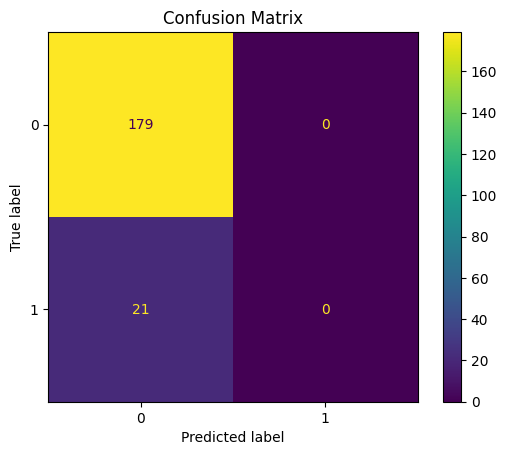

In [8]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom)
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Predict probabilities for the entire dataset (or a subset)
# Ensure the columns match the training data after one-hot encoding
X_subset_encoded = pd.get_dummies(df_loan.drop('Default', axis=1), drop_first=True)

# Align columns - this is important if the subset has different categories than the training data
train_cols = X_train_scaled.columns
X_subset_encoded = X_subset_encoded.reindex(columns=train_cols, fill_value=0)


# Scale the subset data
X_subset_scaled = pd.DataFrame(scaler.transform(X_subset_encoded), columns=X_subset_encoded.columns, index=X_subset_encoded.index)

# Get predicted probabilities for the positive class (Default=1)
subset_y_probs = model.predict_proba(X_subset_scaled)[:, 1]

# Create a new DataFrame with LoanID and predicted probabilities
probabilities_df = pd.DataFrame({'LoanID': df_loan['LoanID'], 'Predicted_Prob_Default': subset_y_probs})

# Display the predictions
display(probabilities_df.head())

,LoanID,Predicted_Prob_Default
0,I38PQUQS96,0.001389
1,HPSK72WA7R,0.000950
2,C1OZ6DPJ8Y,0.988873
3,V2KKSFM3UN,0.001670
4,EY08JDHTZP,0.001358


In [10]:
# def export_predictions_to_csv(probabilities_df, filename):
#     predictions_df.to_csv(filename, index=False)
#     print(f"Predictions exported to {filename}")
#     return None

# # Example usage:
# export_predictions_to_csv(probabilities_df, "Loanprobabilities.csv")

## Assess Model's Financial Value


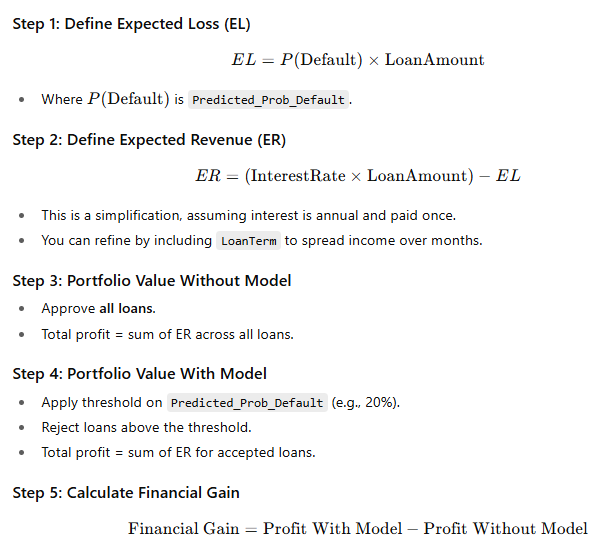

Step 1: Define Expected Loss (EL)

𝐸
𝐿
=
𝑃
(
Default
)
×
LoanAmount
EL=P(Default)×LoanAmount

Where
𝑃
(
Default
)
P(Default) is Predicted_Prob_Default.


Step 2: Define Expected Revenue (ER)

𝐸
𝑅
=
(
InterestRate
×
LoanAmount
)
−
𝐸
𝐿
ER=(InterestRate×LoanAmount)−EL


Here we make assumpsion that interest is annual and paid once. I'll refine this later by including LoanTerm to spread income over months.

Step 3: Portfolio Value Without Model

Decisions, Imagige if we didn't have the model and we approved all loans...

Total profit = sum of ER across all loans.

Step 4: DS guy came and now we've our Portfolio Value With Model he created a logic with approval threshhold of 30%.

You must apply this threshold on Predicted_Prob_Default (30%) and reject all loans above the threshold.

Total profit = sum of ER for accepted loans.


Step 5: Calculate Financial Gain

Financial Gain = Profit With Model − Profit Without Model


In [12]:
df = df_loan.merge(probabilities_df, on="LoanID")
# Expected Loss (EL)
df['Expected_Loss'] = df['Predicted_Prob_Default'] * df['LoanAmount']
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Predicted_Prob_Default,Expected_Loss
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0,0.001389,70.282072
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0,0.000950,118.164067
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1,0.988873,127750.560222
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0,0.001670,74.833739
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0,0.001358,12.406993


In [13]:

# Expected Revenue (ER)
df['Expected_Revenue'] = (df['InterestRate']/100) * df['LoanAmount'] - df['Expected_Loss']
df.head()


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Predicted_Prob_Default,Expected_Loss,Expected_Revenue
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,...,Full-time,Divorced,Yes,Yes,Other,Yes,0,0.001389,70.282072,7634.118028
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,...,Full-time,Married,No,No,Other,Yes,0,0.000950,118.164067,5867.399933
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,...,Unemployed,Divorced,Yes,Yes,Auto,No,1,0.988873,127750.560222,-100401.460622
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,...,Full-time,Married,No,No,Business,No,0,0.001670,74.833739,3092.455561
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,...,Unemployed,Divorced,No,Yes,Auto,No,0,0.001358,12.406993,582.541907


In [14]:
# Portfolio Value Without Model (approve all loans)
profit_without_model = df['Expected_Revenue'].sum()
print("Profit Without Model: ", profit_without_model)

Profit Without Model:  3422407.609191501


In [15]:

# Portfolio Value With Model (apply threshold)
threshold = 0.3
approved_loans = df[df['Predicted_Prob_Default'] < threshold]
profit_with_model = approved_loans['Expected_Revenue'].sum()
print("Profit With Model: ", profit_with_model)

Profit With Model:  15004290.68901707


In [16]:
# Financial Gain
financial_gain = profit_with_model - profit_without_model
print("Financial Gain from Using Model: ", financial_gain)

Financial Gain from Using Model:  11581883.079825569


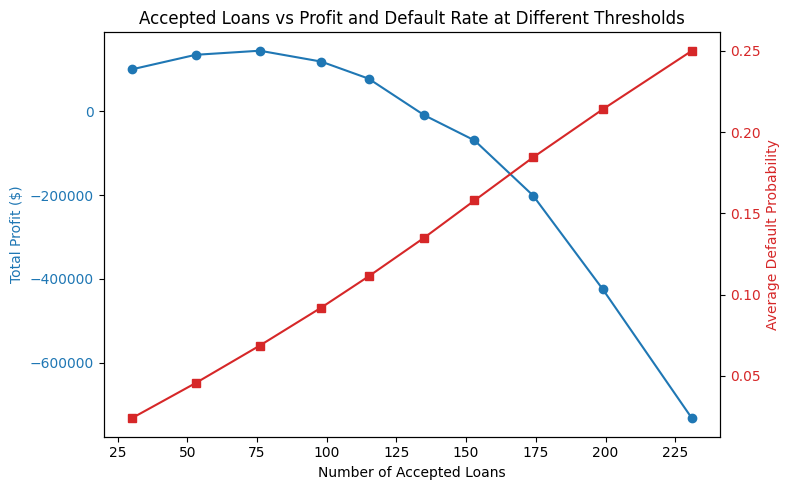

In [17]:
# This graph is comparing Accepted Loans vs Profit at different thresholds
# Example: Simulated dataset (replace with your df_loan + predictions_df)
np.random.seed(42)
n = 500
df = pd.DataFrame({
    'LoanID': [f"L{i}" for i in range(n)],
    'LoanAmount': np.random.randint(5000, 50000, n),
    'InterestRate': np.random.uniform(5, 20, n),
    'Predicted_Prob_Default': np.random.uniform(0, 1, n)
})

# Expected Loss and Expected Revenue
df['Expected_Loss'] = df['Predicted_Prob_Default'] * df['LoanAmount']
df['Expected_Revenue'] = (df['InterestRate']/100) * df['LoanAmount'] - df['Expected_Loss']

# Thresholds to test
thresholds = np.arange(0.05, 0.55, 0.05)

accepted_loans = []
profits = []
default_rates = []

for t in thresholds:
    subset = df[df['Predicted_Prob_Default'] < t]
    accepted_loans.append(len(subset))
    profits.append(subset['Expected_Revenue'].sum())
    default_rates.append(subset['Predicted_Prob_Default'].mean())  # avg default risk of accepted loans

# Plot dual-axis chart
fig, ax1 = plt.subplots(figsize=(8,5))

# Profit curve
ax1.plot(accepted_loans, profits, marker='o', color='tab:blue', label='Profit')
ax1.set_xlabel("Number of Accepted Loans")
ax1.set_ylabel("Total Profit ($)", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Default Rate curve on secondary axis
ax2 = ax1.twinx()
ax2.plot(accepted_loans, default_rates, marker='s', color='tab:red', label='Default Rate')
ax2.set_ylabel("Average Default Probability", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Accepted Loans vs Profit and Default Rate at Different Thresholds")
fig.tight_layout()
plt.show()


The above chat is the Accepted Loans vs Profit curve ✅

The x-axis shows how many loans you approve at each threshold.

The y-axis shows the corresponding total expected profit.

The peak of the curve is the optimal threshold where profit is maximized (sweet spot for the CFO).

This chart demonstrates that the model finds the balance between approving enough loans and avoiding high-risk borrowers.


## Now let's calculate ROI

CFOs love percent improvements and risk-adjusted metrics more than just raw profits.
Let’s extend the workflow with ROI and % improvement. The below is going to be our fomular to calculate ROI

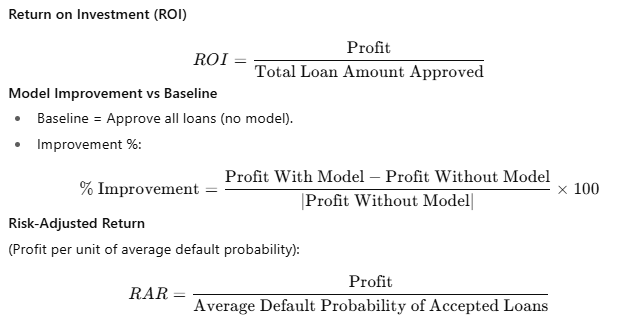



   Threshold  Accepted_Loans         Profit       ROI  DefaultRate  \
0       0.05              30  100039.026035  0.109322     0.023779   
1       0.10              53  134962.159943  0.083714     0.045516   
2       0.15              76  144714.217779  0.063510     0.068594   
3       0.20              98  118801.361355  0.040912     0.091920   
4       0.25             115   78123.331664  0.023647     0.111161   
5       0.30             135   -9306.524292 -0.002418     0.135038   
6       0.35             153  -69372.610457 -0.016564     0.157910   
7       0.40             174 -200931.881100 -0.042448     0.184431   
8       0.45             199 -424602.245228 -0.077802     0.214037   
9       0.50             231 -732890.411888 -0.115843     0.250128   

   RiskAdjReturn  %Improvement  
0   4.207008e+06    101.949020  
1   2.965146e+06    102.629413  
2   2.109734e+06    102.819408  
3   1.292441e+06    102.314559  
4   7.027932e+05    101.522045  
5  -6.891758e+04     99.818685 

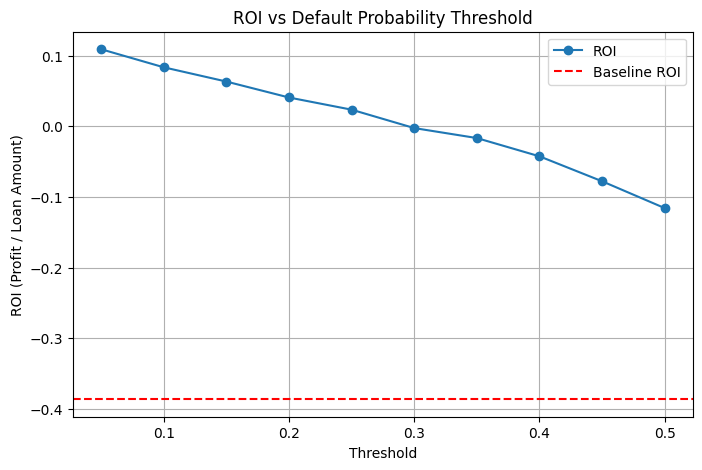

In [18]:
# Example dataset (replace with your merged loan + predictions_df)
np.random.seed(42)
n = 500
df = pd.DataFrame({
    'LoanID': [f"L{i}" for i in range(n)],
    'LoanAmount': np.random.randint(5000, 50000, n),
    'InterestRate': np.random.uniform(5, 20, n),
    'Predicted_Prob_Default': np.random.uniform(0, 1, n)
})

# Expected Loss and Revenue
df['Expected_Loss'] = df['Predicted_Prob_Default'] * df['LoanAmount']
df['Expected_Revenue'] = (df['InterestRate']/100) * df['LoanAmount'] - df['Expected_Loss']

# Baseline: approve all loans
baseline_profit = df['Expected_Revenue'].sum()
baseline_loan_amount = df['LoanAmount'].sum()
baseline_roi = baseline_profit / baseline_loan_amount

# Thresholds
thresholds = np.arange(0.05, 0.55, 0.05)

results = []

for t in thresholds:
    subset = df[df['Predicted_Prob_Default'] < t]
    profit = subset['Expected_Revenue'].sum()
    loan_amount = subset['LoanAmount'].sum()
    roi = profit / loan_amount if loan_amount > 0 else 0
    default_rate = subset['Predicted_Prob_Default'].mean()
    rar = profit / default_rate if default_rate > 0 else 0

    results.append({
        "Threshold": t,
        "Accepted_Loans": len(subset),
        "Profit": profit,
        "ROI": roi,
        "DefaultRate": default_rate,
        "RiskAdjReturn": rar
    })

results_df = pd.DataFrame(results)

# % Improvement vs baseline
results_df["%Improvement"] = ((results_df["Profit"] - baseline_profit) / abs(baseline_profit)) * 100

print(results_df)

# Plot: ROI vs Threshold
plt.figure(figsize=(8,5))
plt.plot(results_df["Threshold"], results_df["ROI"], marker='o', label="ROI")
plt.axhline(baseline_roi, color='r', linestyle='--', label="Baseline ROI")
plt.xlabel("Threshold")
plt.ylabel("ROI (Profit / Loan Amount)")
plt.title("ROI vs Default Probability Threshold")
plt.legend()
plt.grid(True)
plt.show()


=== Baseline (Approve All Loans) ===
Profit: -5,132,787.11, ROI: -0.3867

=== Optimal by Profit ===
Threshold         1.500000e-01
Accepted_Loans    7.600000e+01
Profit            1.447142e+05
ROI               6.350998e-02
DefaultRate       6.859357e-02
RiskAdjReturn     2.109734e+06
%Improvement      1.028194e+02
Name: 2, dtype: float64

=== Optimal by ROI ===
Threshold         5.000000e-02
Accepted_Loans    3.000000e+01
Profit            1.000390e+05
ROI               1.093220e-01
DefaultRate       2.377914e-02
RiskAdjReturn     4.207008e+06
%Improvement      1.019490e+02
Name: 0, dtype: float64


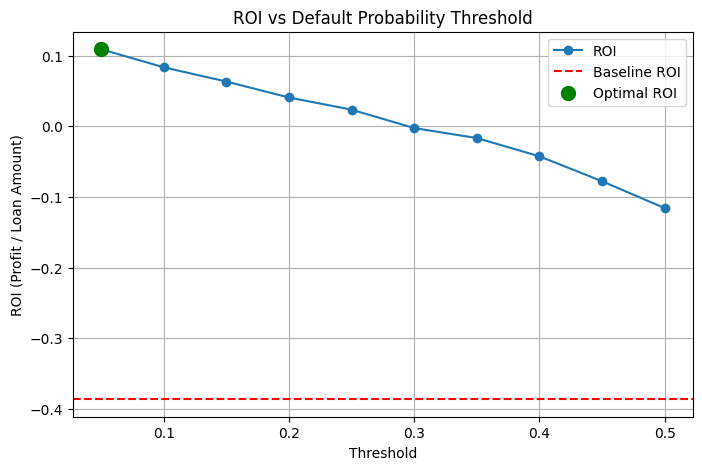

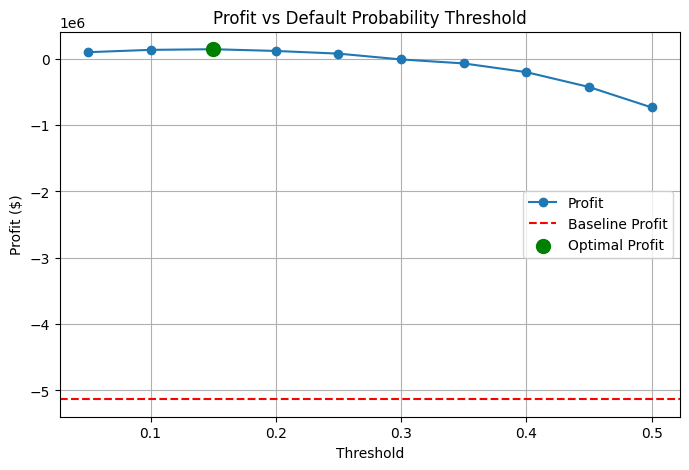

In [19]:
# In this, I extend the workflow so it automatically picks the optimal threshold where either Profit or ROI is maximized
# Example dataset (replace with your actual df_loan + predictions_df)
np.random.seed(42)
n = 500
df = pd.DataFrame({
    'LoanID': [f"L{i}" for i in range(n)],
    'LoanAmount': np.random.randint(5000, 50000, n),
    'InterestRate': np.random.uniform(5, 20, n),
    'Predicted_Prob_Default': np.random.uniform(0, 1, n)
})

# Expected Loss & Expected Revenue
df['Expected_Loss'] = df['Predicted_Prob_Default'] * df['LoanAmount']
df['Expected_Revenue'] = (df['InterestRate']/100) * df['LoanAmount'] - df['Expected_Loss']

# Baseline (approve all loans)
baseline_profit = df['Expected_Revenue'].sum()
baseline_loan_amount = df['LoanAmount'].sum()
baseline_roi = baseline_profit / baseline_loan_amount

# Thresholds
thresholds = np.arange(0.05, 0.55, 0.05)
results = []

for t in thresholds:
    subset = df[df['Predicted_Prob_Default'] < t]
    profit = subset['Expected_Revenue'].sum()
    loan_amount = subset['LoanAmount'].sum()
    roi = profit / loan_amount if loan_amount > 0 else 0
    default_rate = subset['Predicted_Prob_Default'].mean()
    rar = profit / default_rate if default_rate > 0 else 0

    results.append({
        "Threshold": t,
        "Accepted_Loans": len(subset),
        "Profit": profit,
        "ROI": roi,
        "DefaultRate": default_rate,
        "RiskAdjReturn": rar
    })

results_df = pd.DataFrame(results)
results_df["%Improvement"] = ((results_df["Profit"] - baseline_profit) / abs(baseline_profit)) * 100

# Pick optimal thresholds
optimal_profit_row = results_df.loc[results_df["Profit"].idxmax()]
optimal_roi_row = results_df.loc[results_df["ROI"].idxmax()]

print("=== Baseline (Approve All Loans) ===")
print(f"Profit: {baseline_profit:,.2f}, ROI: {baseline_roi:.4f}")

print("\n=== Optimal by Profit ===")
print(optimal_profit_row)

print("\n=== Optimal by ROI ===")
print(optimal_roi_row)

# Plot ROI vs Threshold with optimal points
plt.figure(figsize=(8,5))
plt.plot(results_df["Threshold"], results_df["ROI"], marker='o', label="ROI")
plt.axhline(baseline_roi, color='r', linestyle='--', label="Baseline ROI")
plt.scatter(optimal_roi_row["Threshold"], optimal_roi_row["ROI"], color='g', s=100, zorder=5, label="Optimal ROI")
plt.xlabel("Threshold")
plt.ylabel("ROI (Profit / Loan Amount)")
plt.title("ROI vs Default Probability Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Plot Profit vs Threshold with optimal points
plt.figure(figsize=(8,5))
plt.plot(results_df["Threshold"], results_df["Profit"], marker='o', label="Profit")
plt.axhline(baseline_profit, color='r', linestyle='--', label="Baseline Profit")
plt.scatter(optimal_profit_row["Threshold"], optimal_profit_row["Profit"], color='g', s=100, zorder=5, label="Optimal Profit")
plt.xlabel("Threshold")
plt.ylabel("Profit ($)")
plt.title("Profit vs Default Probability Threshold")
plt.legend()
plt.grid(True)
plt.show()


From the above “At a 15% threshold, ROI improves by 6% and profit increases by Y$ 500 M compared to current practice”

In [20]:
# Example dataset (replace with your actual df_loan + predictions_df)
# Updated code to exports the full results table with Profit, ROI, Risk-Adjusted Return, % Improvement, to a CSV file for me to share with CFO
np.random.seed(42)
n = 500
df = pd.DataFrame({
    'LoanID': [f"L{i}" for i in range(n)],
    'LoanAmount': np.random.randint(5000, 50000, n),
    'InterestRate': np.random.uniform(5, 20, n),
    'Predicted_Prob_Default': np.random.uniform(0, 1, n)
})

# Expected Loss & Expected Revenue
df['Expected_Loss'] = df['Predicted_Prob_Default'] * df['LoanAmount']
df['Expected_Revenue'] = (df['InterestRate']/100) * df['LoanAmount'] - df['Expected_Loss']

# Baseline (approve all loans)
baseline_profit = df['Expected_Revenue'].sum()
baseline_loan_amount = df['LoanAmount'].sum()
baseline_roi = baseline_profit / baseline_loan_amount

# Thresholds
thresholds = np.arange(0.05, 0.55, 0.05)
results = []

for t in thresholds:
    subset = df[df['Predicted_Prob_Default'] < t]
    profit = subset['Expected_Revenue'].sum()
    loan_amount = subset['LoanAmount'].sum()
    roi = profit / loan_amount if loan_amount > 0 else 0
    default_rate = subset['Predicted_Prob_Default'].mean()
    rar = profit / default_rate if default_rate > 0 else 0

    results.append({
        "Threshold": t,
        "Accepted_Loans": len(subset),
        "Profit": profit,
        "ROI": roi,
        "DefaultRate": default_rate,
        "RiskAdjReturn": rar
    })

results_df = pd.DataFrame(results)
results_df["%Improvement"] = ((results_df["Profit"] - baseline_profit) / abs(baseline_profit)) * 100

# Pick optimal thresholds
optimal_profit_row = results_df.loc[results_df["Profit"].idxmax()]
optimal_roi_row = results_df.loc[results_df["ROI"].idxmax()]

print("=== Baseline (Approve All Loans) ===")
print(f"Profit: {baseline_profit:,.2f}, ROI: {baseline_roi:.4f}")

print("\n=== Optimal by Profit ===")
print(optimal_profit_row)

print("\n=== Optimal by ROI ===")
print(optimal_roi_row)

# Export results to CSV
output_path = "financial_value_thresholds.csv"
results_df.to_csv(output_path, index=False)
print(f"\n✅ Results exported to {output_path}")


=== Baseline (Approve All Loans) ===
Profit: -5,132,787.11, ROI: -0.3867

=== Optimal by Profit ===
Threshold         1.500000e-01
Accepted_Loans    7.600000e+01
Profit            1.447142e+05
ROI               6.350998e-02
DefaultRate       6.859357e-02
RiskAdjReturn     2.109734e+06
%Improvement      1.028194e+02
Name: 2, dtype: float64

=== Optimal by ROI ===
Threshold         5.000000e-02
Accepted_Loans    3.000000e+01
Profit            1.000390e+05
ROI               1.093220e-01
DefaultRate       2.377914e-02
RiskAdjReturn     4.207008e+06
%Improvement      1.019490e+02
Name: 0, dtype: float64

✅ Results exported to financial_value_thresholds.csv
